In [1]:
import pandas as pd

In [2]:
dataset = pd.read_csv('Smart_Culinary_Training_Data.csv')


In [3]:
dataset.head()

,Food_Name,Category_ID,Raw_Weight_g,Cooking_Method,Fat_Added_tbsp,Raw_Calories,Raw_Fat_g,Target_Final_Weight_g,Target_Final_Calories
0,"Pillsbury Golden Layer Buttermilk Biscuits, Ar...",18,100,Roast,2,307.0,0,104.4,575.9
1,"Pillsbury, Cinnamon Rolls with Icing, refriger...",18,100,Roast,0,330.0,0,76.4,291.1
2,"Kraft Foods, Shake N Bake Original Recipe, Coa...",18,100,Roast,1,377.0,0,92.9,491.3
3,"George Weston Bakeries, Thomas English Muffins",18,100,Roast,0,232.0,0,79.8,232.2
4,"Waffles, buttermilk, frozen, ready-to-heat",18,100,Roast,1,273.0,0,95.2,407.6


In [4]:
dataset['Category_ID'].unique()

array([18, 23, 19, 11, 24, 25, 14,  4,  7,  1,  3,  5, 10,  8, 16, 15,  9,
       20, 12, 13, 22, 21,  2,  6, 17])

In [5]:
dataset.isnull().sum()

,0
Food_Name,0
Category_ID,0
Raw_Weight_g,0
Cooking_Method,0
Fat_Added_tbsp,0
Raw_Calories,0
Raw_Fat_g,0
Target_Final_Weight_g,0
Target_Final_Calories,0


In [6]:
dataset.describe()

,Category_ID,Raw_Weight_g,Fat_Added_tbsp,Raw_Calories,Raw_Fat_g,Target_Final_Weight_g,Target_Final_Calories
count,7793.000000,7793.0,7793.000000,7793.000000,7793.0,7793.000000,7793.000000
mean,12.632619,100.0,0.544591,220.243118,0.0,99.011087,277.735378
std,6.062021,0.0,0.781159,168.752033,0.0,9.724523,187.241874
min,1.000000,100.0,0.000000,0.000000,0.0,76.000000,0.000000
25%,9.000000,100.0,0.000000,91.000000,0.0,94.400000,128.100000
50%,13.000000,100.0,0.000000,183.000000,0.0,100.700000,260.500000
75%,17.000000,100.0,1.000000,317.000000,0.0,105.700000,387.500000
max,25.000000,100.0,2.000000,902.000000,0.0,118.600000,1225.000000


In [7]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder
encoder = OneHotEncoder(drop='first', dtype=int, sparse_output=False)

# Encode the 'Cooking_Method' column
encoded_array = encoder.fit_transform(dataset[['Cooking_Method']])
encoded_columns = encoder.get_feature_names_out(['Cooking_Method'])

# Create a DataFrame from the encoded data
encoded_df = pd.DataFrame(encoded_array, columns=encoded_columns, index=dataset.index)

# Concatenate the new numerical columns to the original dataset
dataset = pd.concat([dataset, encoded_df], axis=1)

# Drop the original text 'Cooking_Method' column (since we now have the numeric version)
# We also drop 'Food_Name' as it is not a trainable feature
dataset.drop(columns=['Cooking_Method', 'Food_Name'], inplace=True)

print("Encoding complete. Current columns:")
print(dataset.columns)

Encoding complete. Current columns:
Index(['Category_ID', 'Raw_Weight_g', 'Fat_Added_tbsp', 'Raw_Calories',
       'Raw_Fat_g', 'Target_Final_Weight_g', 'Target_Final_Calories',
       'Cooking_Method_Fry', 'Cooking_Method_Microwave',
       'Cooking_Method_Pan-Sear', 'Cooking_Method_Roast',
       'Cooking_Method_Steam'],
      dtype='object')


In [8]:
# Define Features (X) - Using ALL available columns
x = dataset.drop(columns=['Target_Final_Calories'])

# Define Target (y)
y = dataset['Target_Final_Calories']

In [9]:
from sklearn.model_selection import train_test_split

# Split the data (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

print("Training data shape:", x_train.shape)
print("Testing data shape:", x_test.shape)
print("Training data shape:", y_train.shape)
print("Testing data shape:", y_test.shape)

Training data shape: (6234, 11)
Testing data shape: (1559, 11)
Training data shape: (6234,)
Testing data shape: (1559,)


In [10]:
import joblib


In [11]:
#addition
joblib.dump(x_train.columns.tolist(), "model_columns.joblib")


['model_columns.joblib']

In [12]:
from sklearn.ensemble import RandomForestRegressor

# --- IMPROVED MODEL PARAMETERS ---
# Removed 'max_features=1' so the model can see all data (Fat, Weight, etc.)
rf_regressor = RandomForestRegressor(
    n_estimators=200,         # Increased trees for better accuracy
    max_depth=None,           # Let the trees grow deep enough to learn relationships
    min_samples_split=2,      # Allow more precise splits
    random_state=42
)

# Fit the model to the training data
rf_regressor.fit(x_train, y_train)

print("✅ Model retraining complete with improved parameters.")

# Check scores immediately
train_score = rf_regressor.score(x_train, y_train)
test_score = rf_regressor.score(x_test, y_test)
print(f"New Training Score (R²): {train_score:.4f}")
print(f"New Testing Score (R²): {test_score:.4f}")

✅ Model retraining complete with improved parameters.
New Training Score (R²): 0.9975
New Testing Score (R²): 0.9808


🔍 Feature Importance Ranking:
            Feature Name  Importance Score
            Raw_Calories            1862.0
   Target_Final_Weight_g            1517.0
             Category_ID             817.0
          Fat_Added_tbsp             224.0
      Cooking_Method_Fry              95.0
    Cooking_Method_Steam              66.0
    Cooking_Method_Roast              36.0
 Cooking_Method_Pan-Sear              28.0
Cooking_Method_Microwave              24.0


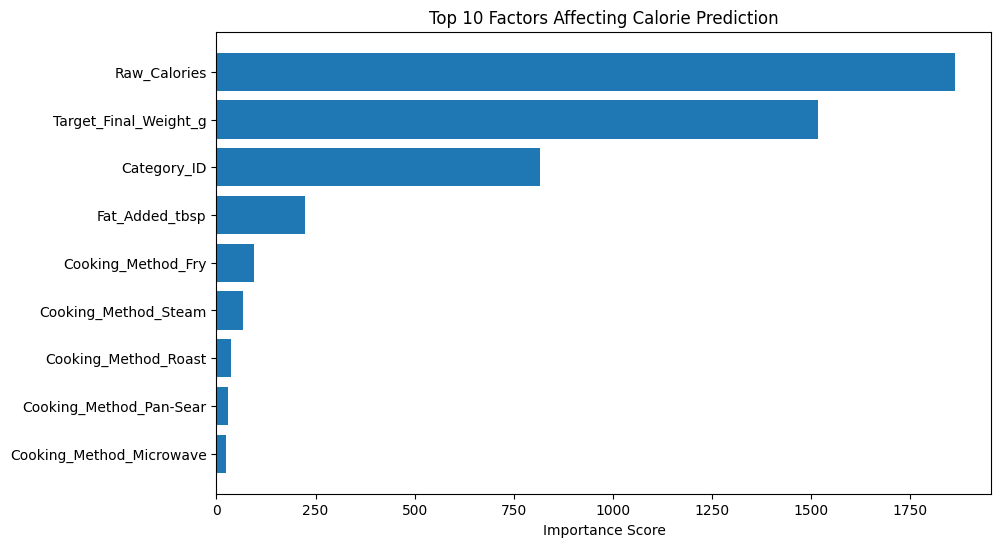

In [13]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================
# FEATURE IMPORTANCE ANALYSIS
# ==========================================

# 1. Initialize the XGBoost model
# We use this just for analysis to see which columns matter most
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    random_state=42
)

# 2. Train on your FULL training set (x_train from the previous step)
xgb_model.fit(x_train, y_train)

# 3. Extract feature importance
# 'weight' counts how many times a feature is used to make a decision in the trees
feature_importances = xgb_model.get_booster().get_score(importance_type='weight')

# 4. Create a DataFrame to view the results
importance_df = pd.DataFrame(list(feature_importances.items()),
                             columns=['Feature Name', 'Importance Score'])

# Sort by importance (highest to lowest)
importance_df = importance_df.sort_values(by='Importance Score', ascending=False)

# 5. Print the results
print("🔍 Feature Importance Ranking:")
print(importance_df.to_string(index=False))

# Optional: Plot the top 10 features for better visualization
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature Name'].head(10), importance_df['Importance Score'].head(10))
plt.xlabel("Importance Score")
plt.title("Top 10 Factors Affecting Calorie Prediction")
plt.gca().invert_yaxis() # Highest importance at the top
plt.show()

In [14]:
# Calculate scores
train_score = rf_regressor.score(x_train, y_train)
test_score = rf_regressor.score(x_test, y_test)

print(f"Training Score (R²): {train_score:.4f}")
print(f"Testing Score (R²): {test_score:.4f}")

Training Score (R²): 0.9975
Testing Score (R²): 0.9808


In [15]:
import pandas as pd
import numpy as np

# ==========================================
# 1. GET R² SCORE
# ==========================================
r2_score = rf_regressor.score(x_test, y_test)
print(f"📈 Model R² Score: {r2_score:.5f}")
print("-" * 30)

# ==========================================
# 2. GENERATE 100 RANDOM TEST VALUES
# ==========================================
np.random.seed(42) # Fixed seed for reproducibility
n = 100

# Generate base features
synthetic_data = {
    'Category_ID': np.random.randint(1, 26, n),
    'Raw_Weight_g': np.full(n, 100),        # Constant (matches training data)
    'Fat_Added_tbsp': np.random.choice([0, 1, 2], n),
    'Raw_Calories': np.random.uniform(0, 900, n),
    'Raw_Fat_g': np.full(n, 0),             # Constant (matches training data)
    'Target_Final_Weight_g': np.random.uniform(76, 120, n)
}

# Generate Cooking Methods (One-Hot Encoded)
# We pick a random method for each row, then convert it to binary columns
possible_methods = ['Boil', 'Fry', 'Microwave', 'Pan-Sear', 'Roast', 'Steam']
chosen_methods = np.random.choice(possible_methods, n)

# Identify the cooking columns expected by the model
# (We filter columns from x_train that start with 'Cooking_Method_')
model_cooking_cols = [c for c in x_train.columns if 'Cooking_Method_' in c]

# Populate the binary columns (0 or 1)
for col in model_cooking_cols:
    method_name = col.replace('Cooking_Method_', '')
    # If the chosen method matches the column name, put 1, else 0
    synthetic_data[col] = (chosen_methods == method_name).astype(int)

# Create the DataFrame
random_test_df = pd.DataFrame(synthetic_data)

# IMPORTANT: Reorder columns to match exactly what the model was trained on
random_test_df = random_test_df[x_train.columns]

# ==========================================
# 3. PREDICT & DISPLAY RESULTS
# ==========================================
predictions = rf_regressor.predict(random_test_df)

# Create a clean results table
results_df = random_test_df.copy()
results_df['PREDICTED_CALORIES'] = predictions

# Select specific columns to display (matching your request)
display_cols = [
    'Category_ID',
    'Raw_Calories',
    'Target_Final_Weight_g',
    'Fat_Added_tbsp',
    'PREDICTED_CALORIES'
]

print("📊 Final Prediction Results (First 10 shown):")
print(results_df[display_cols].head(10).to_string(index=False))

# If you want to see all 100, you can use:
# print(results_df[display_cols].to_string(index=False))

📈 Model R² Score: 0.98084
------------------------------
📊 Final Prediction Results (First 10 shown):
 Category_ID  Raw_Calories  Target_Final_Weight_g  Fat_Added_tbsp  PREDICTED_CALORIES
           7    303.853654              97.670779               0            288.2375
          20    848.618734              84.590691               2           1073.7345
          15    290.882639             107.787893               0            289.9645
          11    466.911560              88.353984               0            446.9180
           8    632.717063              77.069903               2            764.6930
          21    327.266642             104.400781               2            557.9190
           7    874.603874              83.792870               2           1059.7610
          19    866.202565             117.380178               0            822.6390
          23    226.604066             117.972857               2            464.7965
          11    447.523655            

For ui


In [16]:
!pip install streamlit pyngrok


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 113.4 MB/s eta 0:00:00


In [17]:
from pyngrok import ngrok
ngrok.set_auth_token("36EvfgGvZ9MWB9KOITaveXwO7gX_6Bdod216rmTmFE7r9xuSH")


In [18]:
import joblib

# Save the new, smarter model
joblib.dump(rf_regressor, "rf_model.joblib")
joblib.dump(x_train.columns, "model_columns.joblib") # Ensure columns are saved
joblib.dump(encoder, "encoder.joblib")

print("✅ New model and system files saved!")

✅ New model and system files saved!


In [19]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import pickle
import joblib
from sklearn.preprocessing import OneHotEncoder

# ======================================
# CATEGORY LIST (1–25)
# ======================================
CATEGORY_MAP = {
    1: "100 Dairy and Egg Products",
    2: "200 Spices and Herbs",
    3: "300 Baby Foods",
    4: "400 Fats and Oils",
    5: "500 Poultry Products",
    6: "600 Soups, Sauces, and Gravies",
    7: "700 Sausages and Luncheon Meats",
    8: "800 Breakfast Cereals",
    9: "900 Fruits and Fruit Juices",
    10: "1000 Pork Products",
    11: "1100 Vegetables and Vegetable Products",
    12: "1200 Nut and Seed Products",
    13: "1300 Beef Products",
    14: "1400 Beverages",
    15: "1500 Finfish and Shellfish Products",
    16: "1600 Legumes and Legume Products",
    17: "1700 Lamb, Veal, and Game Products",
    18: "1800 Baked Products",
    19: "1900 Sweets",
    20: "2000 Cereal Grains and Pasta",
    21: "2100 Fast Foods",
    22: "2200 Meals, Entrees, and Side Dishes",
    23: "2500 Snacks",
    24: "3500 American Indian/Alaska Native Foods",
    25: "3600 Restaurant Foods"
}

# ======================================
# STREAMLIT UI
# ======================================
st.title("🍽 Smart Culinary Calorie Predictor")

st.subheader("📌 Food Category Guide (1–25)")
for key, value in CATEGORY_MAP.items():
    st.write(f"**{key}. {value}**")

st.markdown("---")

# ======================================
# USER INPUT
# ======================================
st.header("🔢 Enter Food Details")

category_id = st.number_input("Select Food Category (1–25)", min_value=1, max_value=25, step=1)

raw_calories = st.number_input("Raw Calories (kcal)", min_value=0.0, format="%.2f")
raw_weight = st.number_input("Raw Weight (g)", min_value=0.0, format="%.2f")
raw_fat = st.number_input("Raw Fat (g)", min_value=0.0, format="%.2f")
fat_added_tbsp = st.number_input("Fat Added (tablespoons)", min_value=0.0, format="%.2f")
target_final_weight = st.number_input("Target Final Cooked Weight (g)", min_value=0.0, format="%.2f")

cooking_method = st.selectbox(
    "Select Cooking Method",
    ["Boil", "Steam", "Deep_Fry", "Pan_Fry", "Bake", "Roast", "Air_Fry", "Microwave"]
)

# ======================================
# LOAD MODEL + ENCODER + MODEL COLUMNS
# ======================================
@st.cache_resource
def load_artifacts():
    # Load encoder training dataset
    dataset = pd.read_csv("Smart_Culinary_Training_Data.csv")

    encoder = OneHotEncoder(drop="first", sparse_output=False)
    encoder.fit(dataset[["Cooking_Method"]])

    # Load trained RF model
    with open("rf_model.pkl", "rb") as f:
        model = pickle.load(f)

    # Load correct column order
    model_columns = joblib.load("model_columns.joblib")

    return model, encoder, model_columns

model, encoder, model_columns = load_artifacts()

# ======================================
# PREDICTION
# ======================================
if st.button("Predict Final Calories"):
    try:
        # Build raw input dict
        input_data = {
            "Category_ID": category_id,
            "Raw_Weight_g": raw_weight,
            "Fat_Added_tbsp": fat_added_tbsp,
            "Raw_Calories": raw_calories,
            "Raw_Fat_g": raw_fat,
            "Target_Final_Weight_g": target_final_weight,
        }

        df_input = pd.DataFrame([input_data])

        # Encode cooking method
        encoded_df = pd.DataFrame(
            encoder.transform([[cooking_method]]),
            columns=encoder.get_feature_names_out(["Cooking_Method"])
        )

        # Merge numerical + encoded
        final_df = pd.concat([df_input, encoded_df], axis=1)

        # Reorder columns to EXACT training order
        final_df = final_df.reindex(columns=model_columns, fill_value=0)

        prediction = model.predict(final_df)[0]

        st.success(f"🔥 Estimated Final Calories: **{prediction:.2f} kcal**")

    except Exception as e:
        st.error(f"❌ Error: {str(e)}")


Writing app.py


In [20]:
!streamlit run app.py &>/dev/null&


In [21]:
import joblib
joblib.dump(rf_regressor, "rf_model.joblib")


['rf_model.joblib']

In [22]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib
import numpy as np

# =====================================================
# CONFIGURATION
# =====================================================
st.set_page_config(
    page_title="Smart Culinary Predictor",
    page_icon="🍽",
    layout="centered"
)

# =====================================================
# RESOURCE LOADING
# =====================================================
@st.cache_resource
def load_resources():
    dataset = pd.read_csv("Smart_Culinary_Training_Data.csv")
    model = joblib.load("rf_model.joblib")
    encoder = joblib.load("encoder.joblib")
    model_columns = joblib.load("model_columns.joblib")
    return dataset, model, encoder, model_columns

try:
    dataset, model, encoder, model_columns = load_resources()
except Exception as e:
    st.error(f"Error loading resources: {e}")
    st.stop()

# =====================================================
# UI: HEADER & MODE SELECTION
# =====================================================
st.title("🍽 Smart Culinary Calorie Predictor")
st.markdown("Calculate final calories based on **Food**, **Portion Size**, **Added Fat**, and **Cooking Method**.")
st.markdown("---")

# Ask the user: Do you want to use our database or your own numbers?
input_mode = st.radio(
    "How would you like to enter data?",
    ["Select from Food List", "Enter Custom Manual Data"],
    horizontal=True
)

st.markdown("---")

# =====================================================
# UI: DYNAMIC INPUTS
# =====================================================
col1, col2 = st.columns(2)

# --- LEFT COLUMN: FOOD DETAILS ---
with col1:
    st.subheader("1. Food Details")

    if input_mode == "Select from Food List":
        # MODE A: Database Lookup
        food_name = st.selectbox("Select Food Item", sorted(dataset["Food_Name"].unique()))

        # Look up reference values
        ref_row = dataset[dataset["Food_Name"] == food_name].iloc[0]
        base_ref_weight = float(ref_row["Raw_Weight_g"])
        base_ref_cal = float(ref_row["Raw_Calories"])
        base_ref_fat = float(ref_row["Raw_Fat_g"])
        base_cat_id = ref_row["Category_ID"]

        # User adjusts the weight only
        user_weight = st.number_input("Raw Weight (g)", min_value=1.0, value=base_ref_weight, step=10.0, format="%.2f")

        # Calculate Input Calories/Fat based on weight ratio
        scale_factor = user_weight / base_ref_weight if base_ref_weight > 0 else 1.0

        # These are the values we will send to the logic
        final_input_calories = base_ref_cal * scale_factor
        final_input_fat = base_ref_fat * scale_factor

        # Display the auto-calculated values for transparency
        st.info(f"📊 Auto-Calculated Base Content:\n\n**{final_input_calories:.0f} kcal** | **{final_input_fat:.1f}g fat**")

    else:
        # MODE B: Manual Entry
        # User types everything manually
        user_weight = st.number_input("Raw Weight (g)", min_value=1.0, value=100.0, step=10.0)
        final_input_calories = st.number_input("Total Raw Calories (kcal)", min_value=0.0, value=100.0, step=10.0)
        final_input_fat = st.number_input("Total Raw Fat (g)", min_value=0.0, value=0.0, step=1.0)

        # For manual entry, we default to Category 11 (Vegetables) or 22 (Meals) as a generic fallback
        # because the user didn't pick a specific food category.
        base_cat_id = 11

# --- RIGHT COLUMN: COOKING DETAILS ---
with col2:
    st.subheader("2. Cooking Details")

    # Cooking Method
    cooking_method = st.selectbox("Cooking Method", encoder.categories_[0])

    # Fat Added
    fat_added_tbsp = st.number_input("Fat Added (tbsp)", min_value=0.0, value=0.0, step=0.5, format="%.2f")

# =====================================================
# HYBRID PREDICTION LOGIC
# =====================================================
if st.button("🔥 Predict Final Calories", type="primary"):
    try:
        # Estimate Final Weight (Heuristic: most foods retain 80-90% weight or gain water)
        # We use a rough estimate since we don't have a DB reference for custom foods
        estimated_final_weight = user_weight * 0.9

        # 1. ENCODE COOKING METHOD
        encoded_matrix = encoder.transform([[cooking_method]])
        encoded_df = pd.DataFrame(encoded_matrix, columns=encoder.get_feature_names_out(['Cooking_Method']))

        # 2. AI PREDICTION (BASE FOOD ONLY)
        # We use the Hybrid trick: Send Fat_Added = 0 to the AI model
        input_dict = {
            "Category_ID": base_cat_id,
            "Raw_Calories": final_input_calories,   # User provided or Database scaled
            "Raw_Fat_g": final_input_fat,           # User provided or Database scaled
            "Raw_Weight_g": user_weight,
            "Fat_Added_tbsp": 0.0,                  # Force 0 for base prediction
            "Target_Final_Weight_g": estimated_final_weight
        }

        full_input = pd.concat([pd.DataFrame([input_dict]), encoded_df], axis=1)

        # Reindex to match training columns perfectly
        full_input = full_input.reindex(columns=model_columns, fill_value=0)

        # Get AI prediction for the food itself
        base_prediction = model.predict(full_input)[0]

        # 3. MANUAL MATH FOR FAT (1 tbsp = ~120 kcal)
        fat_calories_math = fat_added_tbsp * 120.0

        # 4. FINAL SUM
        final_prediction = base_prediction + fat_calories_math

        # =====================================================
        # DISPLAY RESULTS
        # =====================================================
        st.success(f"### Estimated Final Calories: {final_prediction:,.0f} kcal")

        with st.expander("ℹ️  See Calculation Breakdown"):
            st.write("Calculation Logic:")
            c1, c2, c3 = st.columns(3)
            c1.metric("Base Raw Calories", f"{final_input_calories:.0f}")
            c2.metric("Fat Added (Manual)", f"+{fat_calories_math:.0f} kcal")
            c3.metric("Predicted Total", f"{final_prediction:.0f} kcal")

    except Exception as e:
        st.error(f"Prediction Error: {e}")

Overwriting app.py


In [23]:
!pkill ngrok


In [24]:
public_url = ngrok.connect(8501)
public_url


<NgrokTunnel: "https://tameika-unreleasing-sociologically.ngrok-free.dev" -> "http://localhost:8501">